# MLLib Development Notes

Reverse time order - Newest on top

13 June 2022
- With the June 11 fix to prune_loss, I am now getting the behavior I would like.  
- networks/cell2d.py ConvBR.ArchitectureWeights adds:
    ```python
    weight_basis = GaussianBasis(self.channel_scale)
    ```
- GaussianBasis of channel_scale become 0 as self.channel_scale moves farther from 0
- With this fix, prune_loss no longer increases architecture reduction as illustrated in the 10 June 2022 entry
- prune_loss does not increase cross_entropy loss when applied as is see with dais in the 8 June 2022 entry
- prune_loss appears not to have stopped architecture_reduction as dais dais did in the 8 June 2022 entry
- There is  a significant reduction of compute time with the pruned network.  
- The reduction is less than the architecture_reduction
- Cross  entropy loss before and after pruning close
![crisplit_20220611i_tb](../img/crisplit_20220611i_tb.png)
- Initial results show that channel_scale converges well to target architecture_reduction (e.g. 0.1) without overshoot
- Does targeting a 0-size network and letting the search stabilize result in a drop of inference accuracy?
- Determine what is limiting the inference time of the pruned network
- Compare architectural loss vs pruned loss with and without batch norm
- Compare architectural loss vs pruned loss based on channel scale vs architectural loss vs channel norm
- Why are relaxed-test results so poor?  I think there is a bug somewhere


10 June 2022
- Training to 0 resulted in model pruning to 0
- Sudden application of prune_loss function did not reduce cross entropy loss
- Architecture reduction increased prune_loss increased
![](../img/crisplit_20220609h_tb.png)
- I would like architecture reduction towards 0 to increase cross entropy loss
- Why would it not?  
- When the whole network -> 0, batch norm and argmax normalize the magnitude
- Should the crisp magnitude be scaled so the minimum is 0 and the maximum is 1?
- This would eliminate fully collapsing a layer without a 2-level optimization
- This would eliminate fully expressing a layer without growing logic without a method to grow a network
- Removing BatchNorm would allow a convolution to be minimized without scaling it back
- Removing BatchNorm would allow convolution weights to be scaled oppositely from crisp weights to get both a good convolutional loss and architectural loss
- architectural weight could be the norm of the convolution channel rather than a separate value - this may significantly increase the backpropegation time
- Why did prune basis accelerate rather than slow architectural loss?
- prune_loss is based on sigmoid output
- It looks like as written now prune_loss pushes the model to 0.  There is no gaussian function applied, just sigmoid.
- Fix to gaussian of input for prune loss



8 June 2022
- Beginning with crisplit_20220604i0_01 pre-training, CRISP training with the dais ejector:
![Dais ejector](../img/crisplit_20220607i_dais.png)
- 0.02634 remaining ration with 0.87584 miou is good
- Note the flattening of the CRISP/architecture_loss curve at about the point sigmoid scale increases. 
- Note the flattening of the CRISP/architecture_reduction curve at about the point sigmoid scale increases.  
- The small gradients of the stiffened sigmoid eliminates further change of the loss metric
- Note increase in cross entropy loss at the point sigmoid scale increases.
- I done believe I see this increase in the prune basis ejector
- There is a small of a jump between the orange pre-pruned and blue post-pruned cross entropy loss.  
- Fine tuning the pruned network eliminated this difference
- I interpret this as expected good behavior
- DAIS is effective at pushing most weights do on (red) or off (blue)
- Pruning creates a class bottlenetck in U-NET which is opposite the human-designed network
- Test shape on COCO with a large number of classes

![Stiffened class weights](../img/crisplit_20220607i0_02_cw.png)
![Pruned class weights](../img/crisplit_20220607i0_03_cw.png)

- Rerun with prune_basis for comparison

7 June, 2022

|Model                 | Pretrain CEL |CRISP CEL | Prune CEL | Pretrain MIOU | CRISP MIOU | Prune MIOU |Architecture Reduction| Remaning ratio | Ejector     | 
|---                   |---           |---       |---        |---            |---         |---         |---                   |---             |---          |
|crisplit_20220528i    | 0.01230      |0.00536   |0.01000    | 0.85783       | 0.85783    | 0.87133    | 0.11769              | 0.03235        | prune_basis |
|crisplit_20220606i0   | 0.01230      |0.00536   |0.01000    | 0.85783       | 0.85783    | 0.87133    | 0.11769              | 0.01779        | dais        |
|crisplit_20220606h    | 0.01230      |0.00474   |0.01271    | 0.85783       | NA         | NA         | 0.00556              | 0.0            | prune_basis |

CEL: cross entropy loss 
miou: mean intersection/union 

- sigmod_scale remained constant at 5.
- Rerun ramping sigmoid scale from 5 to 500



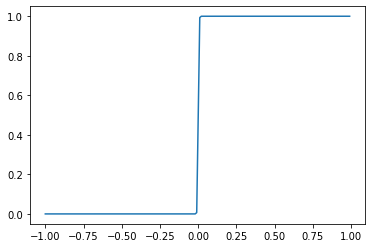

In [21]:
import numpy as np

def sigmoid(x, k):
    return 1/(1+np.exp(-1*k*x))

x = np.arange(-1.0, 1.0, 0.01)
k = 500
plt.plot(x, sigmoid(x, k=k))
plt.show()

6 June 2022
- Disabled training workers and trained on 1 GPU
- Training file read did not fail in 2 tests.
- "normalized train" and "train" without CRISP
- "train-fine" enabled CRISP
    ![Workflow](../img/crisplit_20220604i0_03Workflow.png)
- crisplit.yaml - train-fine architecture reduction to ~ 1%
    cross_entropy_loss: 0.002407548250630498 
    architecture_loss: 0.0008281217887997627 
    prune_loss: 0.02555544488132 
    architecture_reduction: 0.008281217887997627
- Pruned network 0 9 parameters:
    ```cmd
    +--------------------------+------------+
    |         Modules          | Parameters |
    +--------------------------+------------+
    | cells.0.cell_convolution |     1      |
    | cells.1.cell_convolution |     1      |
    | cells.2.cell_convolution |     1      |
    | cells.3.cell_convolution |     1      |
    | cells.4.cell_convolution |     1      |
    | cells.5.cell_convolution |     1      |
    | cells.6.cell_convolution |     1      |
    | cells.7.cell_convolution |     1      |
    | cells.8.cell_convolution |     1      |
    +--------------------------+------------+
    Total Trainable Params: 9
    crisplit_20220604i0_03 remaining parameters 9/31051217 = 2.8984371208381304e-07
    ```
- Cross entropy loss looks good through 
    ![Cross Entropy Loss](../img/crisplit_20220604i0_03_cross_entropy_loss.png)
- I would like an easy process of fining the optimal compression without loss of accuracy
- Maybe additional time to reduce prune_loss would be helpful
- Increase prune basis size to push variables more into on or off
- Try dais and compare with prune_basis
- Prevent pruning from pushing all values to 0 - 
- Try target size to value > 0
- Improve architecture reduction computation
- Rerun from train_fine



1 June 2022

- Working Tensorboard passing steps as artifacts through steps
- Add each step as tensorboard subdirectory 

![CRISP Workflow](../img/CRISPWorkflow.png)
![Multistep Tensorboard](../img/MultistepTensorboard.png)

- The prune basis response is unexpected.  
- I would excpect the value to to begin near 0 and increase gradually.
- Instead, this started at 1, became negative and then passed 0.

![Prune Basis](../img/prune_basis.png)

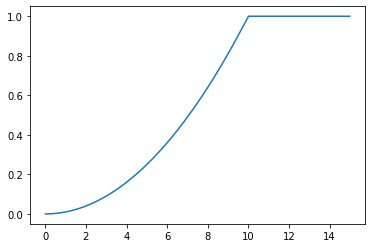

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from pymlutil.functions import Exponential, GaussianBasis


vx = 0.0
vy = 0.0
px = 10.0
py = 1.0
power=2

expf =  Exponential(vx=vx, vy=vy, px=px, py=py, power=power)

x = np.arange(0, px+5, 0.01)
plt.plot(x, expf.f(x))
plt.show()

- Added bounds to Exponential so before vx the output is vy and after px the output is py
- Retest lit with prune_bais and dias

$$ ArchitectureLoss = \frac{L_1(target,  \sum\limits_{}^{Conv2D} sigmoid(k_r)*weights/OutChannels}{\sum weights} ) $$

$$ PruneLoss = \frac{L_2(\sum\limits_{}^{Conv2D} PruneBasis(k_r)}{\sqrt{len(Conv2D)}} $$

$$ TotalLoss = CrossEntropyLoss + k_a \cdot ArchitectureLoss + k_b \cdot PruneLoss $$

27 May, 2022
- Rebuild dockerfile-torch-train:latest locally on HIOCNN - Maybe the failure was not pulling the latest "latest" container and was running on old code
- Changed to 1 worker
- Restarted CRISP coco training on HIOCNN
- Running this morning 7 hours later without failure
- Tensorboard is starting at step 18.  I may not be successfully combining runs into a single tensorboard.
- Try moving each step into a subdirectory.  They should be identified individually then

26 May, 2022
- Added "except" to DecodeImage:
```python
                try:
                    img = cv2.imdecode(imgbuff, flags=self.imflags)
                except:
                    print ("CocoStore::DecodeImage {}/{} cv2.imdecode exception i={}".format(bucket, objectname, i))
                    img = None
```
- Failed again on HIOCNNN in the same way
```cmd
INFO:pytorch_profiler:Run tb loaded
INFO:pytorch_profiler:Add run tb
Traceback (most recent call last):
  File "networks/network2d.py", line 1020, in <module>
    result = main(args)
  File "networks/network2d.py", line 968, in main
    results = Train(args, s3, s3def, class_dictionary, segment, device, results)
  File "networks/network2d.py", line 694, in Train
    data = next(iTest)
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 521, in __next__
    data = self._next_data()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in _next_data
    return self._process_data(data)
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1229, in _process_data
    data.reraise()
  File "/opt/conda/lib/python3.8/site-packages/torch/_utils.py", line 438, in reraise
    raise exception
RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    return self.collate_fn(data)
  File "/opt/conda/lib/python3.8/site-packages/torchdatasetutil/cocostore.py", line 246, in collate_fn
    return torch.utils.data.dataloader.default_collate(batch)
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/_utils/collate.py", line 84, in default_collate
    return [default_collate(samples) for samples in transposed]
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/_utils/collate.py", line 84, in <listcomp>
```

In [2]:
24 May, 2022
- Another data read failure with CRISP on COCO dataset:
```
[  3/50,    240/14785]  loss: 4.86039e-01|4.14557e-01 cross-entropy loss: 4.15798e-01|4.04716e-01 remaining: 9.84038e-01 (train|test) step
time: 0.594

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

INFO:pytorch_profiler:Monitor runs begin
WARNING:urllib3.connectionpool:Retrying (Retry(total=9, connect=5, read=3, redirect=5, status=None)) after connection broken by 'ProtocolEr
ror('Connection aborted.', BadStatusLine('4póO~%\x1b\x9bw?\x8eüôÆéÂØ9ÇP°]\x8bmå\'_|ÖèÔèL Úk\x88]\x8dú]]Ï^¿\x96*0§@z)f*\x9b\x98\x9a¾wªV\x81«
´¥\xad°Ô¦\x96í\x89Ù·ñ{\x0e9\x1døÁ_\x82-\'0*\x91c"Ì)Ä\x84áSõ\x12\x9f$\x96\x94Ðq*Qµ\x87áîIO×\tK\x86N3\x1aÚ\x16wF\x10«\x10êM©\x11ã¶\x17~\t\x07
\x93Ï[â$k¯½Í[·me\x03U¾ä\x80\x90\x9fÝ-µy\x83m\x97p\x0f7ãùaV5ä\x9doÓä\x8eep!¤/\r:©\x01%µI\x0e\\Þü\x80}¾yÁd\x05¢Ç5Q ~\x8e\x1a\x0ekñ\x99%\x17H3
\x80öO{\x8eÿ\x00\x18\x1b¯]\x94\x17\x9fÙ\xadÒÖ5m\x87ÊUMÞE¬Xã§?Ó\x06ìïþº\x0e\x88½\xad´\x86»æµ]\x95\x19Ä¤.l7V¡¹;B\x93´|þ¸ ²,\n'))': /mllib/dat
a/coco/val2017/000000427655.jpg
Corrupt JPEG data: premature end of data segment
INFO:pytorch_profiler:Find run directory /app/tb
INFO:pytorch_profiler:Load run tb
INFO:pytorch_profiler:started all processing
INFO:pytorch_profiler:Run tb loaded
INFO:pytorch_profiler:Add run tb
WARNING:urllib3.connectionpool:Retrying (Retry(total=9, connect=5, read=3, redirect=5, status=None)) after connection broken by 'ProtocolEr
ror('Connection aborted.', BadStatusLine('\x08Ä"\')´\x8f×\x8e\x8a;£\x0bu\x04Ä¡ø\x86qì:\x88úP!=Mç©X\x98\t9<ýsÑ2\x9c\x19Dú\x9cÇ\t\x0cÞ[nVU\x0
7\x1e\x98õéútz\x84\r\\Bæª)\x9cd\x0f\x89qÃ{~]Hfé¥®\x91Xg+ë\x9fÌtêiÍ\x01`¡xx9<\x03\x8e\x84¢.\x04L-Å£Ë\x90²º\x82}\x7f/ùtÅi\x19NÐláw4öä\x99\x0c
»r¸Ç\x1dUº±\x9c+&Sê\x93ÔÚ\x80\x80\x16Le½ÇA\x95\x8cç)áJFR:kCÈ¥Z78ã\x81ýzr¥p>êK(#d°ìUQ\t\x1bÇ©\x1e£Ó¤\x0b\x8ce\x07[#`Ñó.÷]«\x1e2\x1biÉü¿¯DëÐ7
M¶ÈÌ\x85Äßt×Ý\x8c²Ç$\x8d/9Vöêu½Ð"\n'))': /mllib/data/coco/train2017/000000341017.jpg
Corrupt JPEG data: premature end of data segment
Traceback (most recent call last):
  File "networks/network2d.py", line 1020, in <module>
    result = main(args)
  File "networks/network2d.py", line 968, in main
    results = Train(args, s3, s3def, class_dictionary, segment, device, results)
  File "networks/network2d.py", line 694, in Train
    data = next(iTest)
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 521, in __next__
    data = self._next_data()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in _next_data
    return self._process_data(data)
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1229, in _process_data
    data.reraise()
  File "/opt/conda/lib/python3.8/site-packages/torch/_utils.py", line 438, in reraise
    raise exception
RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    return self.collate_fn(data)
  File "/opt/conda/lib/python3.8/site-packages/torchdatasetutil/cocostore.py", line 237, in collate_fn
    return torch.utils.data.dataloader.default_collate(batch)
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/_utils/collate.py", line 84, in default_collate
    return [default_collate(samples) for samples in transposed]
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/_utils/collate.py", line 84, in <listcomp>
    return [default_collate(samples) for samples in transposed]
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/_utils/collate.py", line 56, in default_collate
    return torch.stack(batch, 0, out=out)
RuntimeError: stack expects each tensor to be equal size, but got [480, 512] at entry 0 and [442, 512] at entry 5
```
- Adding S3-level retries didn't appear to fix the problem
- 

SyntaxError: invalid syntax (1011173006.py, line 1)

23 May, 2022
- Training failure on HIOCNN on the weekend run:
    ```cmd
    [ 13/50,    240/14785]  loss: 3.23336e-01|1.37674e-01 cross-entropy loss: 3.68384e-01|1.28495e-01 remaining
    : 9.17939e-01 (train|test) step time: 0.595
    100%|██████████| 2/2 [00:00<00:00,  7.88it/s]

    NOTE: Using experimental fast data loading logic. To disable, pass
        "--load_fast=false" and report issues on GitHub. More details:
        https://github.com/tensorflow/tensorboard/issues/4784

    INFO:pytorch_profiler:Monitor runs begin
    INFO:pytorch_profiler:Find run directory /app/tb
    INFO:pytorch_profiler:Load run tb
    INFO:pytorch_profiler:started all processing
    INFO:pytorch_profiler:Run tb loaded
    INFO:pytorch_profiler:Add run tb
    WARNING:tensorboard:In 3.0, this warning will become an error:
    Requires default-src for Content-Security-Policy
    WARNING:urllib3.connectionpool:Retrying (Retry(total=2, connect=None, read=None, redirect=None, status=None
    )) after connection broken by 'ProtocolError('Connection aborted.', BadStatusLine('Kå\x08\x9d\x00ó½¾\x18ä\x
    80\x000\x94Mc\x9a\x8d\x80\x8dÁ8\\R[ôGÒ-n7©J\t)T\x01¹Â{\x93Úm¶QAK\x10B\x86\x92yíþ°\x94\x94\x12r\x17¢\xa0¬\x9
    1ª\x06Ð0à\x8aÑ¸¤\x9d%ÍPæãc÷l&Rçþ)4j\x925B\x89\x8b\x1b\x0c6\x93Zò¿&\x98<\x12\x95-J\x04O\x8b¦:©\x11®/m\x14àÃ-
    7\x1e2U\x17½ð\x17:°\x95ÍJ¾êRÙ\x1eñ;Î\x04x´Òê\x19M®Ð%õ\x14\x04ÊEÔI\x89¶"ºÊáè\x11\x94ùy¤\x1e\tÞàtÀ\x1c\x01R£.
    bnÌ\x96ã\x8b-\x9dDLm\x13\x80á¥X:G9»QÙ.N*\x9cm:eV278YeÚËPY\x11/Sð?¦Q\x846\x90\x12\x13\n'))': /mllib/data/coc
    o/train2017/000000528284.jpg
    Corrupt JPEG data: premature end of data segment
    Traceback (most recent call last):
    File "networks/network2d.py", line 1021, in <module>
        result = main(args)
    File "networks/network2d.py", line 969, in main
        results = Train(args, s3, s3def, class_dictionary, segment, device, results)
    File "networks/network2d.py", line 695, in Train
        data = next(iTest)
    File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 521, in __next__
        data = self._next_data()
    File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in _next_data
        return self._process_data(data)
    File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1229, in _process_data
        data.reraise()
    File "/opt/conda/lib/python3.8/site-packages/torch/_utils.py", line 438, in reraise
        raise exception
    RuntimeError: Caught RuntimeError in DataLoader worker process 0.
    Original Traceback (most recent call last):
    File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 287, in _worker_loop
        data = fetcher.fetch(index)
    File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
        return self.collate_fn(data)
    File "/opt/conda/lib/python3.8/site-packages/torchdatasetutil/cocostore.py", line 235, in collate_fn
        return torch.utils.data.dataloader.default_collate(batch)
    File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/_utils/collate.py", line 84, in default_col
    late
        return [default_collate(samples) for samples in transposed]
    File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/_utils/collate.py", line 84, in <listcomp>
        return [default_collate(samples) for samples in transposed]
    File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/_utils/collate.py", line 56, in default_col
    late
        return torch.stack(batch, 0, out=out)
    RuntimeError: stack expects each tensor to be equal size, but got [480, 512] at entry 0 and [393, 512] at e
    ntry 7
    ```
- It looks like a read failure resulted in an incorrect image size.
- Added retries to MINIO reads
- Can network reads be made more reliable
- Because this read failure resulted in an incorrect image size rather than a null buffer, we hat a failure in "cocostore.py", line 235, in collate_fn" rather than loading the next image
- Could this failure have been correlated with my using the MINIO console?

21 May, 2022
- Successfully plot tensorboard across multiple steps in workflow

19 May 2022
- Code is in place to have a continuous tensorboard though a multi-step CRISP training as an Argo workflow
- Failure on first workflow step with an empty artifact input
    ```cmd
    blarson@ipc001:/data/git/mllib$ py utils/workflow.py -s ipc001 -r workflow/seg.yaml -p '{"output_name":"20220519i", "target_structure":0.0, "batch_size":3, "debug": true, "min": true }'
    url: https://192.168.0.155:30992/api/v1/workflows/ml 
    status_code: 500 
    response: {"code":2,"message":"templates.train-crisp.tasks.normalized-train templates.train inputs.artifacts.prevresultspath was not supplied"}
    ```
- see if I can solve this with [conditional artifcats](https://github.com/argoproj/argo-workflows/blob/master/examples/conditional-artifacts.yaml)

17 May 2022
- Adding artifcats to [../workflow/seg.yaml](../workflow/seg.yaml) to pass log intex between steps to produce one continuous tensorboard


16 May 2022
1. How to experiment on convergence?
    - Which convergence tests apply to CNN convergence
        <svg id="svg" viewbox="21.659997940063477,68.5999984741211,268.79998779296875,193.60000610351562" style="height:193.60000610351562"><path d="M 137.26,78.6 L 136.46,79.4 L 136.46,81 L 136.46,84.2 L 136.46,87.4 L 136.46,92.2 L 136.46,101 L 135.66,109 L 135.66,117 L 135.66,125 L 135.66,136.2 L 135.66,144.2 L 135.66,152.2 L 135.66,161 L 135.66,167.4 L 135.66,173 L 135.66,177.8 L 135.66,182.6 L 134.86,185.8 L 134.86,189.8 L 134.06,192.2 L 133.26,195.4 L 132.46,197.8 L 131.66,199.4 L 130.86,201.8 L 130.86,202.6 L 130.86,204.2 L 130.06,205.8 L 130.06,206.6 L 130.06,208.2 L 130.06,209 L 130.86,209 L 131.66,209 L 132.46,209 L 134.06,208.2 L 135.66,208.2 L 138.86,207.4 L 142.86,207.4 L 150.06,206.6 L 157.26,206.6 L 166.86,205.8 L 177.26,205 L 189.26,204.2 L 204.46,204.2 L 216.46,203.4 L 230.06,203.4 L 242.06,203.4 L 255.66,202.6 L 265.26,201.8 L 272.46,201 L 278.06,200.2 L 280.46,200.2" fill="none" stroke="#6190e8" stroke-width="2"></path><path d="M 254.86,81.8 L 254.86,83.4 L 254.86,86.6 L 254.06,89 L 253.26,93.8 L 252.46,97.8 L 250.86,103.4 L 248.46,109 L 246.06,114.6 L 243.66,120.2 L 239.66,127.4 L 234.86,134.6 L 231.66,139.4 L 226.86,144.2 L 221.26,149 L 214.06,155.4 L 208.46,160.2 L 202.06,164.2 L 195.66,168.2 L 189.26,172.2 L 184.46,174.6 L 178.86,177 L 170.86,180.2 L 165.26,183.4 L 161.26,185.8 L 156.46,187.4 L 151.66,189 L 150.06,189 L 149.26,189" fill="none" stroke="#6190e8" stroke-width="2"></path>  <text font-family="inherit" font-size="14" fill="#6190e8" x="140.46" y="249">Cross entropy loss</text><text font-family="inherit" font-size="14" fill="#6190e8" x="32.46" y="149">Architecture Loss</text></svg> 

    - Does convergence depend on initial conditions?
    - Does convergence depend on search method?
1. How to experiment on relaxation?
    - Output difference between relaxed model and pruned model
    - Objective performance of relaxed model and retrained pruned model
    - Sparsity of pruned model
1. How effectively is the space searched



11 May 2021
- Objective: Initialize model with pretrained weights to improve training and convergence
- Observe if there is a relationship between pretrained weights and pruning
- Transfer learning: 
    1. Create full unpruned model
    2. model.load_state_dict(<model weights>, strict=False)

_Convergence and stability_
- There is a lot of discussion of convergence and stability in NAS and structured pruning [STACNAS: TOWARDS STABLE AND CONSISTENT OPTIMIZATION FOR DIFFERENTIABLE NEURAL ARCHITECTURE SEARCH](https://openreview.net/pdf?id=rygpAnEKDH)
- Formal methods to evaluate convergence and stability are missing from deep learning optimization literature
- Stability [Numerical stability](https://en.wikipedia.org/wiki/Numerical_stability#:~:text=The%20usual%20definition%20of%20numerical,)%20%E2%88%92%20y*%20is%20small.), [Stability theory](https://en.wikipedia.org/wiki/Stability_theory)
- Convergence: [Convergent series](https://en.wikipedia.org/wiki/Convergent_series), [Convergence tests](https://en.wikipedia.org/wiki/Convergence_tests), [Conditional convergence](https://en.wikipedia.org/wiki/Conditional_convergence)
- Relaxation similarity to Pruned model with various approaches - Nothing, DAIS, weighting basis function
- Display pruning map across training
- Append Tensorboard across Argo steps
- Quick method to view Tensorboard for specific run from Jupyter
- Once we can view training, evaluate various approaches:
    1. Train -> Prune -> Train -> Prune
    1. Simultaneous train & prune
    1. Train to specific size & prune
    1. Weighting methods from training
    1. [Figure 3 Loss Contours](https://openreview.net/pdf?id=SYuJXrXq8tw)
    1. [Figure 1 Loss surface](https://arxiv.org/pdf/1712.09913.pdf)
- What can be answered about generalization of pruned network?

10 May 2022
- CRISP training of UNET on the LIT dataset takes a few hours
- The same parameters on COCO take a few days
- The COCO dataset is much more diverse than the LIT dataset
- The COCO dataset is 100x larger than the LIT dataset
- A6000 GPU efficiency is 70% on COCO
- I am only using half the available A6000 memory.  Increasing this should reduce the training time
- Look at [Deeplab V3](https://arxiv.org/pdf/1706.05587.pdf) with CRISP
- Deeplab V3 : [Pytorch implementation](https://github.com/pytorch/vision/blob/main/torchvision/models/segmentation/deeplabv3.py)
- Deeplab V3 
    1. encoder
        - resnet of different sizes
        - mobilenet V3
        - ...
    1. classifier - FCN head: Conv2d->Batch Norm->relu->Dropout->Conv2d
    1. Atrous spatial pyramid pooling: list of Atrous convolutions->BatchNorm->Relu followed
    1. Conv->Batch norm->Relu->Dropout across pooling levels
- Add per channel relaxation layer following each conv->batch norm
- Add network weight metric
- Add network pruning function
- How to structure this?
    1. If search and augment network it can be applied to existing networks without rewriting
    1. Instance norm or other norms would be sufficient.  Not just batch norm.
    1. Test pruning with and without norms on problems that where convolution scaling can offset continuous relaxation
    1. Append norm if needed and relaxation layers to network
    1. Efficiently compute architecture loss from augmented network, not class
    1. Efficient prune from network, not class
    1. Begin with cell2d
    1. Explore network-level pruning
    1. What is the effect of network-level pruning on stability and convergence
    1. Metrics for stability and converence


2 May 2022
- The past couple of weeks, I have been splitting off code 
- The python library [pymlutil](https://pypi.org/project/pymlutil/) contains general utility functions
- The python library [torchdatasetuitl](https://pypi.org/project/torchdatasetutil/) contains creating and using datasets
- I will be removing this code from pymlutil soon.
- One goal for this is to enable the dataset to be selected as a parameter
- To do this the input channels and format must to be specified in the network creation.
- I am adding class_dictionary['input_channels'] and class_dictionary['input_type'] to the class_dictionary.  This way, selecting the class dictionary defines the input type
- If the input dataset can be selected by parameter rather than requiring code changes, I would like to enable transfer learning across training sets.
- I would like to pick up the Torch pretrained [UNET](https://pytorch.org/hub/mateuszbuda_brain-segmentation-pytorch_unet/) and [Deeplab V3](https://pytorch.org/hub/pytorch_vision_deeplabv3_resnet101/)
- To enable transfer learning, I need to change from torch.load to model.load_state_dict: https://pytorch.org/tutorials/beginner/basics/saveloadrun_tutorial.html
- torch.load loads the pickled python object which I needed to do previously because pruned state in class variables - e.g. - convolution size after pruning is complete
- Transfer learning only may only work for unpruned models
- After a model is pruned, how would transfer learning from an unpruned model work?  
    - require model pruning weights
    - copy parameters based on pruning weights
    - easier and same result if you initialize the model just before pruning,
    - initialize parameters from transfer learning
    - prune model with weights from transfer learning

    "input_channels":3,
    "input_type": "float32",
- For transfer learning, need to handle changes in input channel depth from 1 to 3 and visa versa - for datasets with grayscale and RGB inputs

8 April 2022
- Training LIT
- Increasing the learning rate 1 2e-4 appears to have pushed the model convergence to train the network to find nothing - always background
- There is a heavy class imbalance
- Adding class weighting to full training
- Next work on switching datasets with parameter
- Add cityscapes dataset
- Add denoise dataset
- Pytorch [Dataset and Dataloaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)
- Uses: load, split, train, test, view
- [datasets/cocostore.py](../datasets/cocostore.py) - loads coco into torch dataset from S3
- [datasets/imstore.py](../datasets/imstore.py) - loads directories of images into torch dataset
- [dataset/citytorch.py](../datasets/citytorch.py) - loads cityscapes to a torch dataset 
- [OpenImages dataset](https://storage.googleapis.com/openimages/web/factsfigures.html)
- Disable augmentation on validation images

4 April 2022
- Scale annealing and prune basis based on start & end points.  
- Switch to exponential function where start and end point are specified
- Initially grow based on epochs
- Experiment with growing based on step to make training more independent of dataset size

2 April 2022
- CRISP training with pruning basis function crisplit_20220401i_pb00_
- Pruned 94% of network while increasing segmentation similarity
- May achieve~ 25X speedup
- Pruning search not strictly 1 and 0.  


[T00cw]: ../img/crisplit_20220401i_pb00_00_cw.png
[T01cw]: ../img/crisplit_20220401i_pb00_01_cw.png
[T02cw]: ../img/crisplit_20220401i_pb00_02_cw.png
[T03cw]: ../img/crisplit_20220401i_pb00_03_cw.png
[T00gn]: ../img/crisplit_20220401i_pb00_00_gn.png
[T01gn]: ../img/crisplit_20220401i_pb00_01_gn.png
[T02gn]: ../img/crisplit_20220401i_pb00_02_gn.png
[T03gn]: ../img/crisplit_20220401i_pb00_03_gn.png
|  | normalized-train | train | train_fine | prune |
|:--:|:--:|:--:|:--:|:--:|
|Cross Entropy Loss|0.163|0.0068|0.0112|0.005|
|Reamining Ratio   |1.0  |0.132 |0.131 |0.057|
|Test similarity   |     |      |0.113 |0.817|
| Prune Weights |![][T00cw]|![][T01cw] |![][T02cw] |![][T03cw]|
| Gradient Norm |![][T00gn]|![][T01gn] |![][T02gn] |![][T03gn]|

- Final losses before pruning:

| Loss               | Value    |
|:------------------:|:--------:|
| cross_entropy_loss | 0.011264 |
| architecture_loss  | 0.001306 |
| prune_loss         | 0.000196 |

- Increasing prune loss should incrase this sepration.


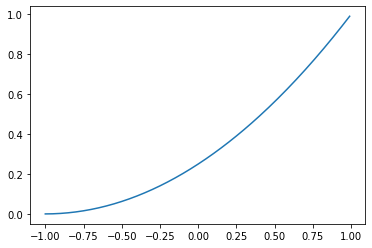

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
class Exponential():
    def __init__(self,vx=0.0, vy=0.0, px=1.0, py=1.0, power=2.0):
        self.vx = vx
        self.vy = vy
        self.px = px
        self.py = py
        if power < 0:
            raise ValueError('Exponential error power {} must be >= 0'.format(power))
        self.power = power
        if px <= vx:
            raise ValueError('Exponential error px={} must be > vx'.format(px, vx))
        else:
            self.a = (py-vy)/np.power(px-vx,power)
    def f(self, x):
        dx = x-self.vx
        y = self.a*np.power(x-self.vx,self.power) + self.vy
        return y

vx = -1
px = 1
expf =  Exponential(vx=vx, vy=0.0, px=px, py=1.0, power=2.0)

x = np.arange(vx, px, 0.01)
plt.plot(x, expf.f(x))
plt.show()

1 April 2022
- Prune loss basis function training to 0 size
- This resulted in much more agressive pruning
- Slightly worse cross entropy loss for train and train_fine
- Much worse cross entropy loss for pruned network
- The tensorboard plots show a similar timing of the architecture reduction curves but with prune_loss, the architecture settles at a lower level.
- Architecture reduction occurs early and converges rapidly compared to cross entropy loss.  
- Reduce k_structure from 0.03 to 0.1 to slow architecture search
- Increase k_prune_basis from 0.01 to 0.3 to see if the resuls in eliminating fence sittes more effectively
- Increase k_prune_exp from 5.0 to 50.0 apply prunce basis later in training

[T00cw]: ../img/crisplit_20220331h_pb0_00_cw.png
[T01cw]: ../img/crisplit_20220331h_pb0_01_cw.png
[T02cw]: ../img/crisplit_20220331h_pb0_02_cw.png
[T03cw]: ../img/crisplit_20220331h_pb0_03_cw.png
[T00gn]: ../img/crisplit_20220331h_pb0_00_gn.png
[T01gn]: ../img/crisplit_20220331h_pb0_01_gn.png
[T02gn]: ../img/crisplit_20220331h_pb0_02_gn.png
[T03gn]: ../img/crisplit_20220331h_pb0_03_gn.png
|  | normalized-train | train | train_fine | prune |
|:--:|:--:|:--:|:--:|:--:|
|Cross Entropy Loss|0.164|0.032|0.020|0.040|
|Reamining Ratio|1.0|0.050|0.041|0.00024|
|Test similarity|  |  |0.106|0.028|
| Prune Weights |![][T00cw]|![][T01cw] |![][T02cw] |![][T03cw]|
| Gradient Norm |![][T00gn]|![][T01gn] |![][T02gn] |![][T03gn]|

- Signmod scale as linear function stiffens very quickly.  Want it to be gradual at the beginning and stiffen towards the end of the training


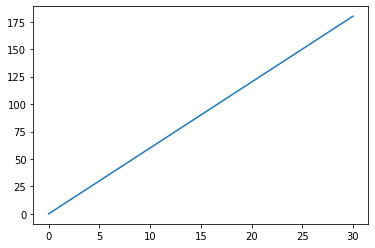

kSigmoid(3)=18.0


NameError: name 'sigmoid' is not defined

In [3]:
from matplotlib import pyplot as plt
def SigmoidScale(step, start_x = 0, end_x = 25, start_y = 0, end_y=100):
    kSigmoid = start_y + (end_y-start_y)*step/(end_x-start_x)
    return kSigmoid
x = np.arange(0.0, 30.0, 0.01)
k_prune_exp = 1
sigmoid_scale = 5
sigmoid_scale_exp = 0.25
plt.plot(x, SigmoidScale(x, end_x=25, end_y=150))
plt.show()

x = np.arange(-1.0, 1.0, 0.01)
step =3
kSigmoid = SigmoidScale(step, end_x=25, end_y=150)
print('kSigmoid({})={}'.format(step, kSigmoid))
plt.plot(x, sigmoid(x, k=kSigmoid))
plt.show()

13 April 2022
- updated [pymlutil](https://github.com/bhlarson/pymlutil) to deliver new tag and pipy version when excuting ./setup
- Added pattern for documentation

12 April 2022
- Added imstore.py CreateDataLoaders to load unique datasets for any number of sets with unique parameters 
- Moving imstore common processing to ImUtil
- Move into  library for dataset loading 